In [1]:
import os
import sys
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class TrOtsu(object):#大津の2値化
    def __init__(self, min_val = 0, max_val = 255):
        self.min_val = min_val
        self.max_val = max_val
    
    def fit_transform(self, img):
        hist = self._calc_hist(img)
        sp_list = np.array([self._calc_sp(hist, hist[:th], hist[th:]) for th in range(256)])
        #分離度が最大の閾値を獲得
        self.max_th = np.argmax(sp_list)
        print(f'Threshold valud = {self.max_th}')
        #画像を2値化して返す
        img[img<self.max_th] = self.min_val
        img[img>=self.max_th] = self.max_val
        return img
    
    def _calc_unv(self, hist):
        #ヒストグラム内のピクセル数
        n = np.sum(hist)
        if n!=0:#0割を防ぐ
            #ヒストグラムの平均輝度
            u = np.sum([i*x for i, x in enumerate(hist)])/n
            #ヒストグラムのクラス内分散
            v = np.sum((hist-u)**2.0)/n
        else:
            u = 0
            v = 0
        return {'n':n, 'u':u, 'v':v}
    
    def _calc_sp(self, all_array, b_array, w_array):
        all_unv = self._calc_unv(all_array)
        b_unv = self._calc_unv(b_array)
        w_unv = self._calc_unv(w_array)
        S1 = (b_unv['n']*(b_unv['u']-all_unv['u'])**2+w_unv['n']*(w_unv['u']-all_unv['u'])**2)
        S2 = (b_unv['n']*b_unv['v']+w_unv['n']*w_unv['v'])
        S = S1/S2
        return S
    
    
    def _calc_hist(self, img):
        return np.array([np.sum(img==i) for i in range(256)])

Threshold valud = 123


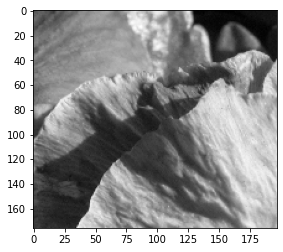

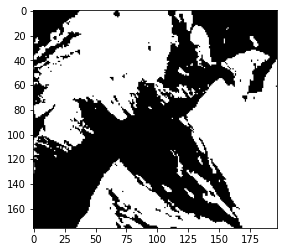

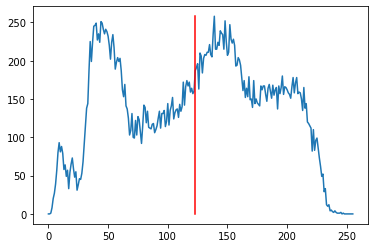

In [3]:
img = Image.open('./t1.png').convert('L')
img_array = np.array(img)
plt.figure()
plt.gray()
plt.imshow(img_array)
#大津の2値化実行
otsu = TrOtsu()
transed_img = otsu.fit_transform(np.copy(img_array))
plt.figure()
plt.gray()
plt.imshow(transed_img)
plt.figure()
plt.plot(np.array([np.sum(img_array==i) for i in range(256)]))
plt.plot([otsu.max_th, otsu.max_th], [ 0, np.max(np.array([np.sum(img_array==i) for i in range(256)]))], "red")

In [4]:
class CHLAC(object):
    def __init__(self):
        self.dim = 3
        if not os.path.exists(f'./chlac_mask.pkl'):
            self.masks = self._calc_masks()
            with open(f'./chlac_mask.pkl', 'wb') as f:
                pickle.dump(self.masks, f)
        else:
            with open(f'./chlac_mask.pkl', 'rb') as f:
                self.masks = pickle.load(f)
        print(self.masks)
        
    def transform(self, img):
        height, width, depth = img.shape
        res = [0 for i in range(len(self.masks))]
        for i in range(height-2):
            for j in range(width-2):
                for k in range(depth-2):
                    img_vec = self._arr2vec(img[i:i+self.dim, j:j+self.dim, k:k+self.dim])
                    for pos_mask, mask in enumerate(self.masks):
                        c1, c2 = 0, 0
                        for pos_img, char in enumerate(mask):
                            if char=="1":
                                c1 += 1
                                if img_vec[pos_img]==255:
                                    c2 += 1
                        if c1 == c2:
                            res[pos_mask] += 1
        return np.array(res)
    
    def _arr2vec(self, array):
        return array.reshape(-1)
    
    def _calc_masks(self):
        #平行移動可能であるかチェックするパターン
        self.chk_list = []
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                for k in [-1, 0, 1]:
                    self.chk_list.append([i, j, k])
        #ベースパターン: 000000000000010000000000000
        base_pattern = np.array([0 if i!=(self.dim**3-1)/2 else 1 for i in range(self.dim**3)]).reshape(self.dim,self.dim,self.dim)
        #マスクパターンリスト
        self.mask_pattern = [base_pattern]
        
        #Start mask pattern search
        for i in range(self.dim):
            for j in range(self.dim):
                for k in range(self.dim):
                    if (i*self.dim+j*self.dim+k)==((self.dim**3-1)/2):
                        continue
                    tmp_pattern = np.copy(base_pattern)
                    tmp_pattern[i, j, k] = 1
                    if self._chk_in_pattern(tmp_pattern):
                        self.mask_pattern.append(tmp_pattern)
                    
                    for i2 in range(self.dim):
                        for j2 in range(self.dim):
                            for k2 in range(self.dim):
                                if((i2==i)&(j2==j)&(k2==k)):
                                    continue
                                tmp_pattern = np.copy(base_pattern)
                                tmp_pattern[i, j, k] = 1
                                tmp_pattern[i2, j2, k2] = 1
                                if self._chk_in_pattern(tmp_pattern):
                                    self.mask_pattern.append(tmp_pattern)
        #End mask pattern search
        mask_list = []
        print(f'Number of mask = {len(self.mask_pattern)}')
        for i,masks in enumerate(self.mask_pattern):
            mask_list.append("".join(str(e) for e in masks.reshape(-1).tolist()))
        return mask_list
    
    def _chk_in_pattern(self, tmp_pattern):
        count = 0
        for mask in self.mask_pattern:
            for chk_idx in range(len(self.chk_list)):
                if self._chk_pattern(tmp_pattern, self.chk_list[chk_idx]):
                    tmp_roll_pattern = np.roll(tmp_pattern, (self.chk_list[chk_idx][0], self.chk_list[chk_idx][1], self.chk_list[chk_idx][2]), axis=(0,1,2))
                    if np.array_equal(mask, tmp_roll_pattern):
                        count+=1
                        break
        if count==0:
            return True
        else:
            return False
    
    
    def _chk_pattern(self, pattern, pattern_list):
        count = 0
        if pattern_list[0]==-1:
            count+=np.sum(pattern[0, :, :])
        if pattern_list[0]==1:
            count+=np.sum(pattern[2, :, :])
        if pattern_list[1]==-1:
            count+=np.sum(pattern[:, 0, :])
        if pattern_list[1]==1:
            count+=np.sum(pattern[:, 2, :])
        if pattern_list[2]==-1:
            count+=np.sum(pattern[:, :, 0])
        if pattern_list[2]==1:
            count+=np.sum(pattern[:, :, 2])
        if count==0:
            return True
        else:
            return False

In [5]:
cubic_img = np.stack([transed_img, transed_img, transed_img], 2)
print(cubic_img.shape)
chlac_vec = CHLAC().transform(cubic_img)
print(f'chlac_vec shape = {chlac_vec.shape}')
print(f'chlac_vec = {chlac_vec}')

(176, 197, 3)
Number of mask = 251
['000000000000010000000000000', '100000000000010000000000000', '110000000000010000000000000', '101000000000010000000000000', '100100000000010000000000000', '100010000000010000000000000', '100001000000010000000000000', '100000100000010000000000000', '100000010000010000000000000', '100000001000010000000000000', '100000000100010000000000000', '100000000010010000000000000', '100000000001010000000000000', '100000000000110000000000000', '100000000000011000000000000', '100000000000010100000000000', '100000000000010010000000000', '100000000000010001000000000', '100000000000010000100000000', '100000000000010000010000000', '100000000000010000001000000', '100000000000010000000100000', '100000000000010000000010000', '100000000000010000000001000', '100000000000010000000000100', '100000000000010000000000010', '100000000000010000000000001', '010000000000010000000000000', '011000000000010000000000000', '010100000000010000000000000', '010010000000010000000000000', '01